In [1]:
import os
import argparse
import pandas as pd
import tensorflow as tf
from bp import Environment
import TransUnet.experiments.config as conf
from dTurk.utils.clr_callback import CyclicLR
import TransUnet.models.transunet as transunet
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from train_helpers import dice_loss, mean_iou, oversampling, create_dataset

Segmentation Models: using `tf.keras` framework.


In [2]:
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

In [3]:
env = Environment()

In [4]:
dataset = "MACH-77-it3"
machine = "local"
monitor = "val_loss"
epochs = 75
patience = 12
batch_size = 32
lr = 0.005
train_augmentation_file = "/Users/srinathramalingam/Desktop/codebase/dTurk/dTurk/augmentation/configs/light.yaml"
save_path = "weights/Unet"
checkpoint_filepath = save_path + "/checkpoint/"

In [5]:
dataset_directory = os.environ.get("BP_PATH_REMOTE") + "/datasets/semseg_base" + "/" + dataset

In [6]:
try:
    gpus = tf.config.list_physical_devices("GPU")
    tf.config.set_visible_devices(gpus[args_dict["gpu"]], "GPU")
except:
    print("Gpus not found")

Gpus not found


In [7]:
train_input_names = [
    dataset_directory + "/train_labels/" + i
    for i in os.listdir(dataset_directory + "/train_labels/")
    if i.endswith(".png")
]
val_input_names = [
    dataset_directory + "/val/" + i for i in os.listdir(dataset_directory + "/val/") if i.endswith(".png")
]

In [8]:
train_input_names = oversampling(train_input_names, machine, dataset, -1)
train_ds_batched, val_ds_batched = create_dataset(train_input_names, val_input_names, train_augmentation=train_augmentation_file)

100%|████████████████████████████████████████████| 90/90 [00:00<00:00, 216.12it/s]
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
2022-06-29 18:30:49.407913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
step_size = int(2.0 * len(train_input_names) / batch_size)

In [10]:
builder = SM_UNet_Builder(
    encoder_name='efficientnetv2-l',
    input_shape=(256, 256, 3),
    num_classes=3,
    activation="softmax",
    train_encoder=False,
    encoder_weights="imagenet",
    decoder_block_type="upsampling",
    head_dropout=0,  # dropout at head
    dropout=0,  # dropout at feature extraction
)

In [11]:
model = builder.build_model()

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [12]:
model.compile(optimizer="adam", loss=dice_loss, metrics=mean_iou)

In [13]:
callbacks = []
cyclic_lr = CyclicLR(
    base_lr=lr / 10.0,
    max_lr=lr,
    step_size=step_size,
    mode="triangular2",
    cyclic_momentum=False,
    max_momentum=False,
    base_momentum=0.8,
)
callbacks.append(cyclic_lr)

early_stopping = EarlyStopping(
    monitor=monitor,
    mode="min" if "loss" in monitor else "max",
    patience=patience,
    verbose=1,
    restore_best_weights=True,
)
callbacks.append(early_stopping)

In [14]:
history = model.fit(
    train_ds_batched, epochs=epochs, validation_data=val_ds_batched, callbacks=[callbacks]
)

Epoch 1/75
11/11 [==============================] - 391s 31s/step - loss: 0.5224 - mean_iou: 0.7493 - val_loss: 0.5063 - val_mean_iou: 0.7048
Epoch 2/75
11/11 [==============================] - 315s 27s/step - loss: 0.4751 - mean_iou: 0.9561 - val_loss: 0.5063 - val_mean_iou: 0.7049
Epoch 3/75
11/11 [==============================] - 303s 28s/step - loss: 0.4730 - mean_iou: 0.9556 - val_loss: 0.5060 - val_mean_iou: 0.7054
Epoch 4/75
11/11 [==============================] - 300s 27s/step - loss: 0.4701 - mean_iou: 0.9698 - val_loss: 0.5054 - val_mean_iou: 0.7049
Epoch 5/75
11/11 [==============================] - 282s 25s/step - loss: 0.4691 - mean_iou: 0.9696 - val_loss: 0.5060 - val_mean_iou: 0.7050
Epoch 6/75
11/11 [==============================] - 289s 26s/step - loss: 0.4685 - mean_iou: 0.9760 - val_loss: 0.5064 - val_mean_iou: 0.7069
Epoch 7/75
11/11 [==============================] - 295s 27s/step - loss: 0.4681 - mean_iou: 0.9773 - val_loss: 0.5052 - val_mean_iou: 0.7187
Epoch 

11/11 [==============================] - 171s 16s/step - loss: 0.4670 - mean_iou: 0.9817 - val_loss: 0.4679 - val_mean_iou: 0.9738
Epoch 59/75
11/11 [==============================] - 166s 14s/step - loss: 0.4674 - mean_iou: 0.9748 - val_loss: 0.4679 - val_mean_iou: 0.9738
Epoch 60/75
11/11 [==============================] - 166s 15s/step - loss: 0.4674 - mean_iou: 0.9767 - val_loss: 0.4681 - val_mean_iou: 0.9725
Epoch 61/75
11/11 [==============================] - 233s 22s/step - loss: 0.4671 - mean_iou: 0.9786 - val_loss: 0.4683 - val_mean_iou: 0.9712
Epoch 62/75
11/11 [==============================] - 294s 24s/step - loss: 0.4671 - mean_iou: 0.9792 - val_loss: 0.4682 - val_mean_iou: 0.9722
Epoch 63/75
11/11 [==============================] - 455s 42s/step - loss: 0.4670 - mean_iou: 0.9816 - val_loss: 0.4681 - val_mean_iou: 0.9727
Epoch 64/75
11/11 [==============================] - 511s 46s/step - loss: 0.4670 - mean_iou: 0.9819 - val_loss: 0.4680 - val_mean_iou: 0.9737
Epoch 65/75

In [16]:
iou = history.history["mean_iou"]
val_iou = history.history["val_mean_iou"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

df = pd.DataFrame(iou)
df.columns = ["mean_iou"]
df["val_mean_iou"] = val_iou
df["loss"] = loss
df["val_loss"] = val_loss

df.to_csv("Unet-logs.csv")

In [21]:
model.save_weights(checkpoint_filepath+'/Unet.h5')
model.load_weights(checkpoint_filepath+'/Unet.h5')
saved_model_path = save_path + "/model"
model.save(saved_model_path)

INFO:tensorflow:Assets written to: weights/Unet/model/assets


INFO:tensorflow:Assets written to: weights/Unet/model/assets


In [23]:
import cv2
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

builder = SM_UNet_Builder(
    encoder_name='efficientnetv2-l',
    input_shape=(256, 256, 3),
    num_classes=3,
    activation="softmax",
    train_encoder=False,
    encoder_weights="imagenet",
    decoder_block_type="upsampling",
    head_dropout=0,  # dropout at head
    dropout=0,  # dropout at feature extraction
)
model2 = builder.build_model()
model2.load_weights("/Users/srinathramalingam/Desktop/codebase/TransUnet/weights/Unet/checkpoint/Unet.h5")

In [27]:
def predict(image, model,):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction = model.predict(img)
    prediction = tf.clip_by_value(prediction, 0.0, 1.0)
    pred = prediction * 255
    pred = np.array(pred).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred

In [28]:
val_input_names = ["/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images/" + i for i in os.listdir("/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images")]

In [33]:
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 337ms/step


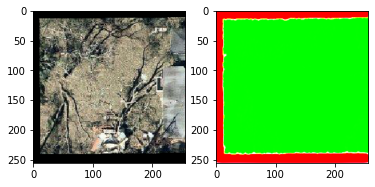

1/1 [==============================] - 0s 321ms/step


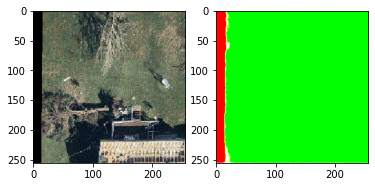

1/1 [==============================] - 0s 333ms/step


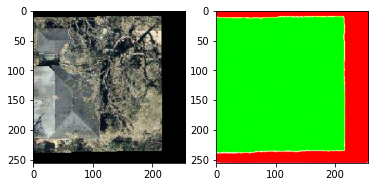

1/1 [==============================] - 0s 331ms/step


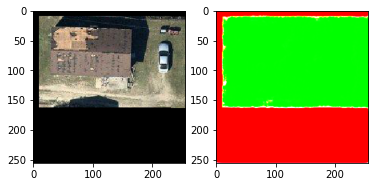

1/1 [==============================] - 0s 336ms/step


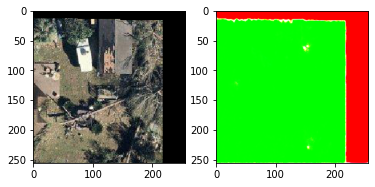

1/1 [==============================] - 0s 337ms/step


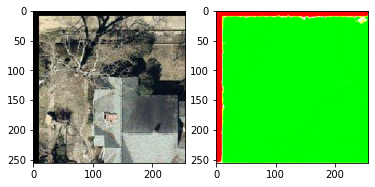

1/1 [==============================] - 0s 343ms/step


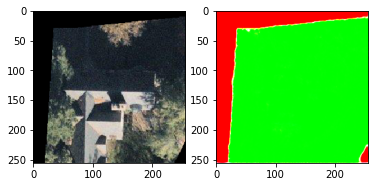

1/1 [==============================] - 0s 334ms/step


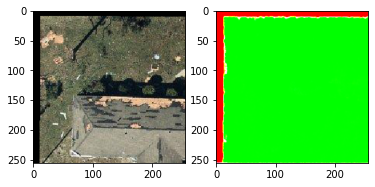

1/1 [==============================] - 0s 326ms/step


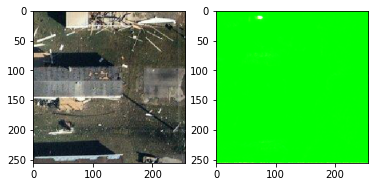

1/1 [==============================] - 0s 319ms/step


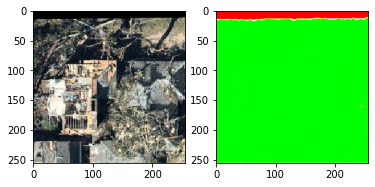

1/1 [==============================] - 0s 355ms/step


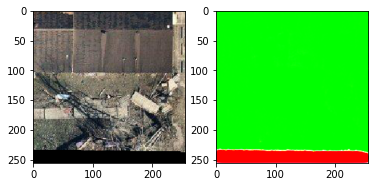

1/1 [==============================] - 0s 331ms/step


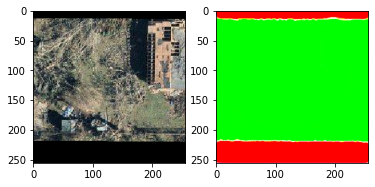

1/1 [==============================] - 0s 325ms/step


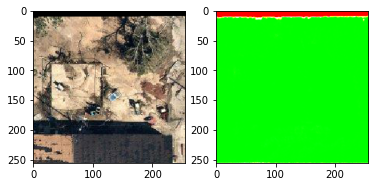

1/1 [==============================] - 0s 324ms/step


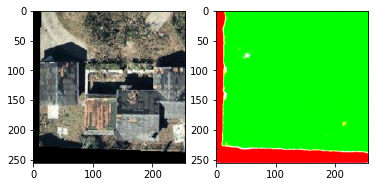

1/1 [==============================] - 0s 339ms/step


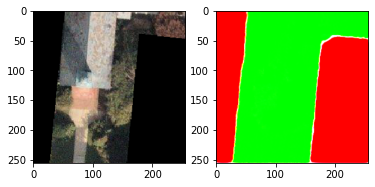

1/1 [==============================] - 0s 333ms/step


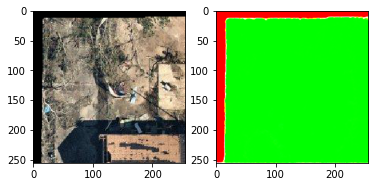

1/1 [==============================] - 0s 328ms/step


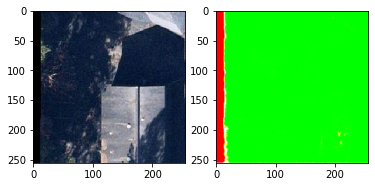

1/1 [==============================] - 0s 338ms/step


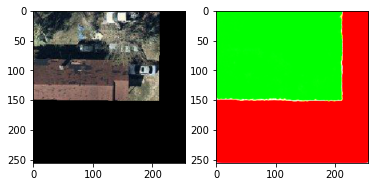

1/1 [==============================] - 0s 338ms/step


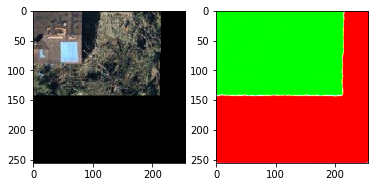

1/1 [==============================] - 0s 332ms/step


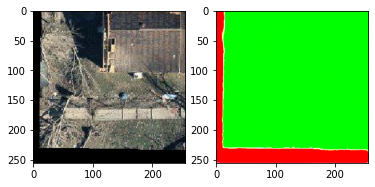

1/1 [==============================] - 0s 335ms/step


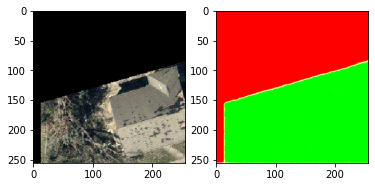

1/1 [==============================] - 0s 345ms/step


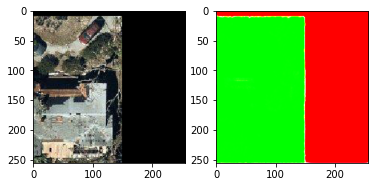

1/1 [==============================] - 0s 352ms/step


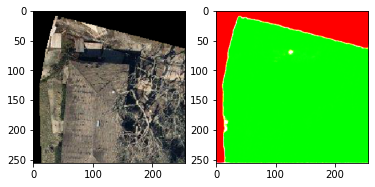

1/1 [==============================] - 0s 333ms/step


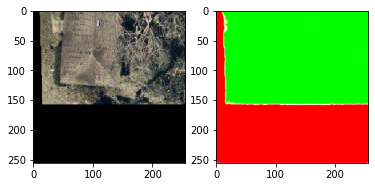

1/1 [==============================] - 0s 345ms/step


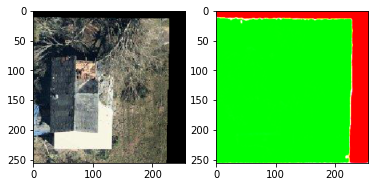

1/1 [==============================] - 0s 347ms/step


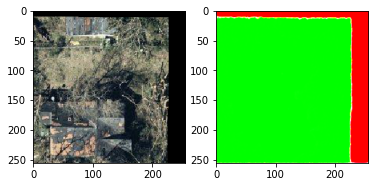

1/1 [==============================] - 0s 367ms/step


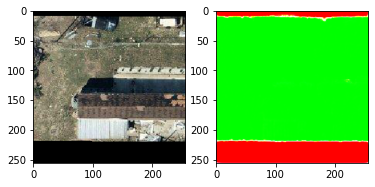

1/1 [==============================] - 0s 338ms/step


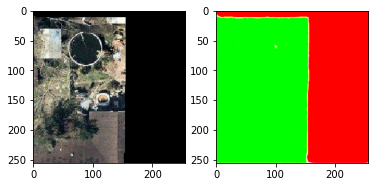

1/1 [==============================] - 0s 346ms/step


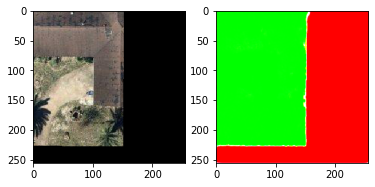

1/1 [==============================] - 0s 343ms/step


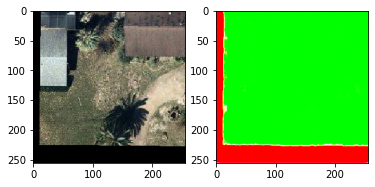

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def predict(image, model,):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction = model.predict(img)
    prediction = tf.clip_by_value(prediction, 0.0, 1.0)
    pred = prediction * 255
    pred = np.array(pred).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred


for file in range(len(val_input_names)):
    img, pred1 = predict(val_input_names[file], model)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(pred1)

    plt.show()